In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
sort_dates=session.query(Measurement.date).order_by(Measurement.date.desc())
print(sort_dates)

SELECT measurement.date AS measurement_date 
FROM measurement ORDER BY measurement.date DESC


In [10]:
latest_date = sort_dates.first()
print(latest_date)
type(latest_date)

('2017-08-23',)


sqlalchemy.engine.row.Row

In [11]:



latest_date_time=dt.datetime.strptime(latest_date[0],"%Y-%m-%d")

In [12]:

print(latest_date_time)

2017-08-23 00:00:00


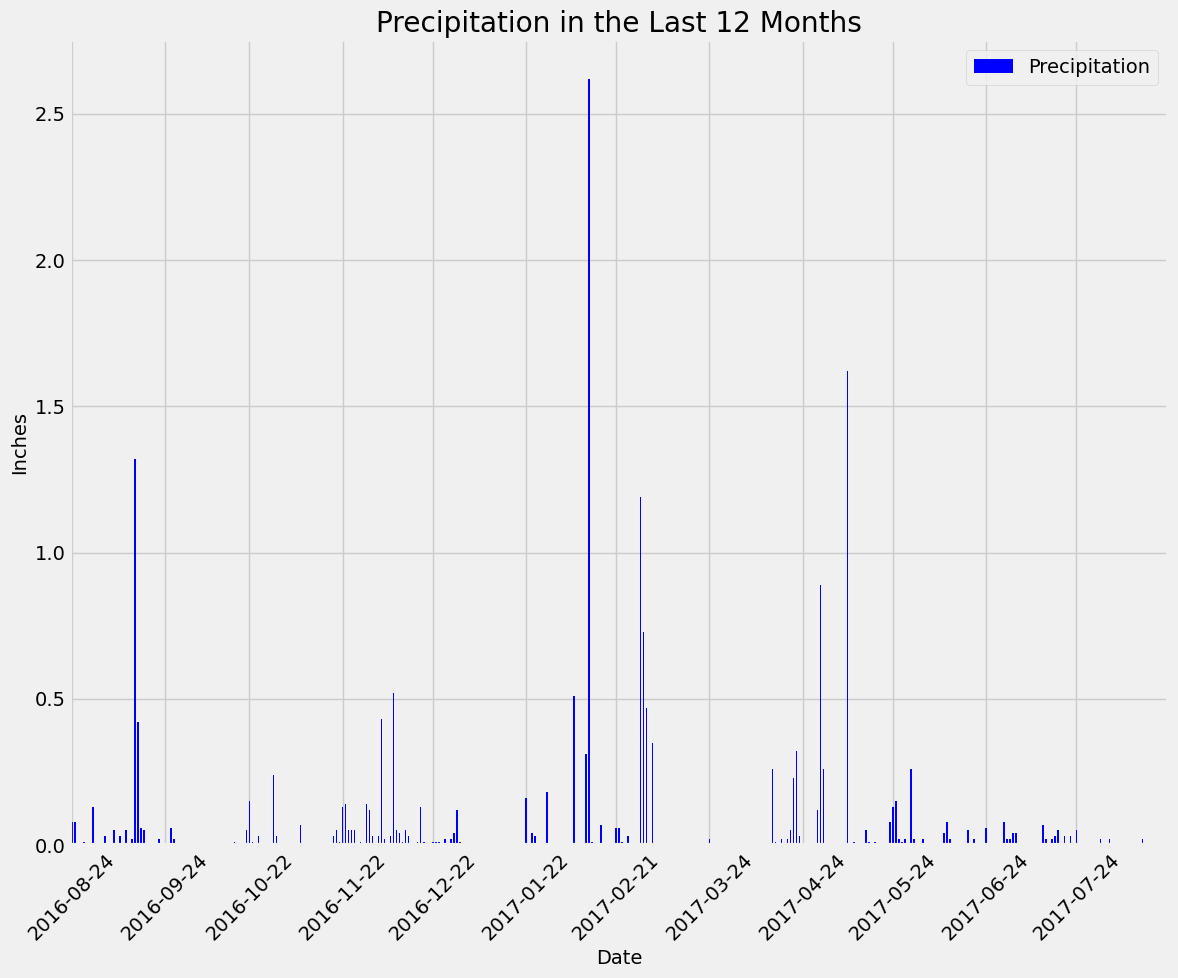

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import timedelta

# Calculate the date one year from the last date in data set.
one_year_ago = latest_date_time-dt.timedelta(days = 365)
#print(one_year_ago)

# Perform a query to retrieve the data and precipitation scores
results=session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date>one_year_ago).group_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
results_df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
sorted_results = results_df.sort_values(by = ['Date'], ascending = True)

# Use Pandas Plotting with Matplotlib to plot the data
sorted_results.plot.bar(x='Date', y='Precipitation', color='b', figsize=(12, 10), legend=True, linewidth=9.0, grid=True)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation in the Last 12 Months')



# Set the frequency of displayed dates (one per month)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())



# Rotate the x-axis labels
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [14]:
print(one_year_ago)

2016-08-23 00:00:00


In [15]:
sorted_results = results_df.sort_values(by='Date')
sorted_results

,Date,Precipitation
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01
...,...,...
360,2017-08-19,0.00
361,2017-08-20,0.00
362,2017-08-21,0.00
363,2017-08-22,0.00


In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
results_df.describe()

,Precipitation
count,363.000000
mean,0.048843
std,0.205197
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,2.620000


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station.id).count()

9

In [19]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
station_counts


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station = station_counts[0][0]
#print(active_station)
session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.station == active_station).all()

[(54.0, 71.66378066378067, 85.0)]

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_results = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == active_station).\
                filter(Measurement.date >= one_year_ago).all()
temp_df = pd.DataFrame(station_results)
temp_df

,station,tobs
0,USC00519281,77.0
1,USC00519281,80.0
2,USC00519281,80.0
3,USC00519281,75.0
4,USC00519281,73.0
...,...,...
346,USC00519281,77.0
347,USC00519281,77.0
348,USC00519281,76.0
349,USC00519281,76.0


<function matplotlib.pyplot.show(close=None, block=None)>

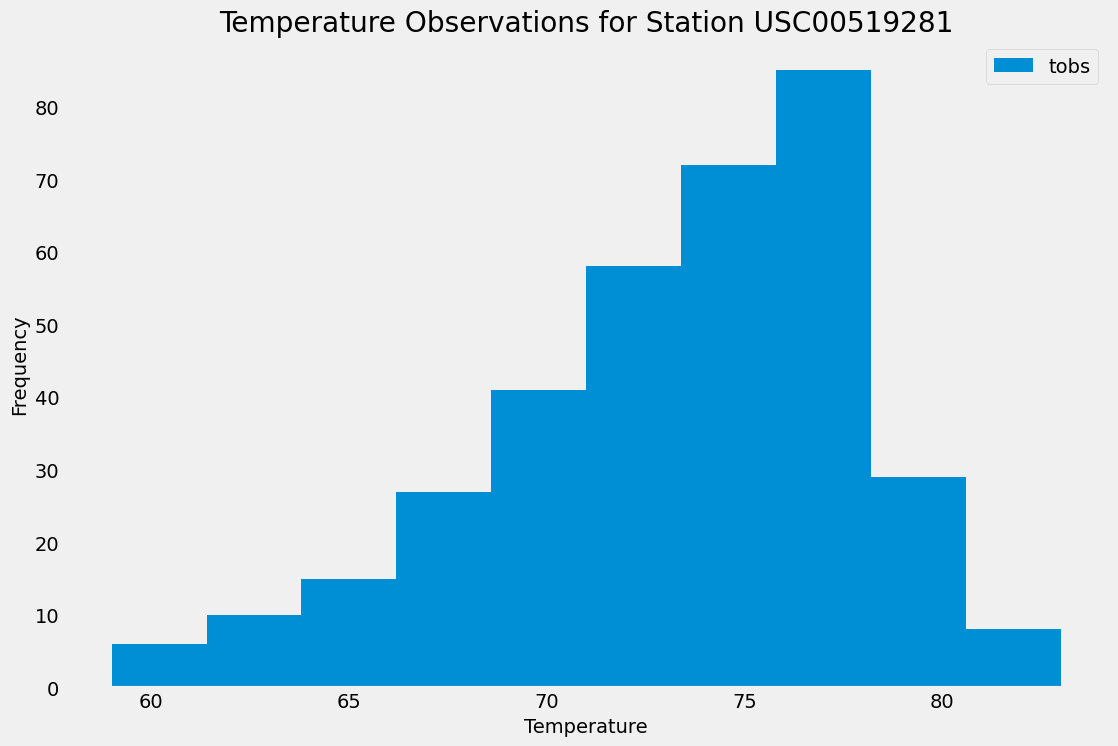

In [22]:
#plot
temp_df.plot.hist(bins=10, figsize=(12,8))
plt.grid()
plt.title("Temperature Observations for Station " + active_station)
plt.xlabel("Temperature")
plt.savefig("StationTemps.png")
plt.show

# Close Session

In [ ]:
# Close Session
session.close()